# ChordGAN Preprocessing

Data exploration of the preprocessing methods for chordGAN

In [1]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob


%load_ext lab_black

# python script, in github repo
print("Numpy version:", np.__version__)

Numpy version: 1.21.2


Use the following to avoid GPU errors (if needed)

## Setup helper functions

These are the functions used directly in the original notebook

In [176]:
# add songs to data
def get_songs(path):
    files = glob.glob("{}/*.mid*".format(path))
    songs = []
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) - if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs.append(song)
        except Exception as e:
            raise e
    return songs


# custom function to extract chroma features from song
def get_chromas(songs):
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(np.shape(song)[0], 12))
        for i in np.arange(np.shape(song)[0]):
            for j in np.arange(78):
                if song[i][j] > 0:
                    chroma[i][np.mod(j, 12)] += 1
        # print(np.shape(chroma))
        chromas.append(chroma)

    return chromas

# Load a sample

In [168]:
fpath = "../data/chordGan/Pop/Pop_Music_Midi"
files = glob.glob("{}/*.mid*".format(fpath))[:5]
sample = files[0]
song_name = sample.split("\\")[-1]
print(f"Sample song name: {song_name}")

sample_midi = pretty_midi.PrettyMIDI(sample)

Sample song name: All The Small Things - Chorus.midi


C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


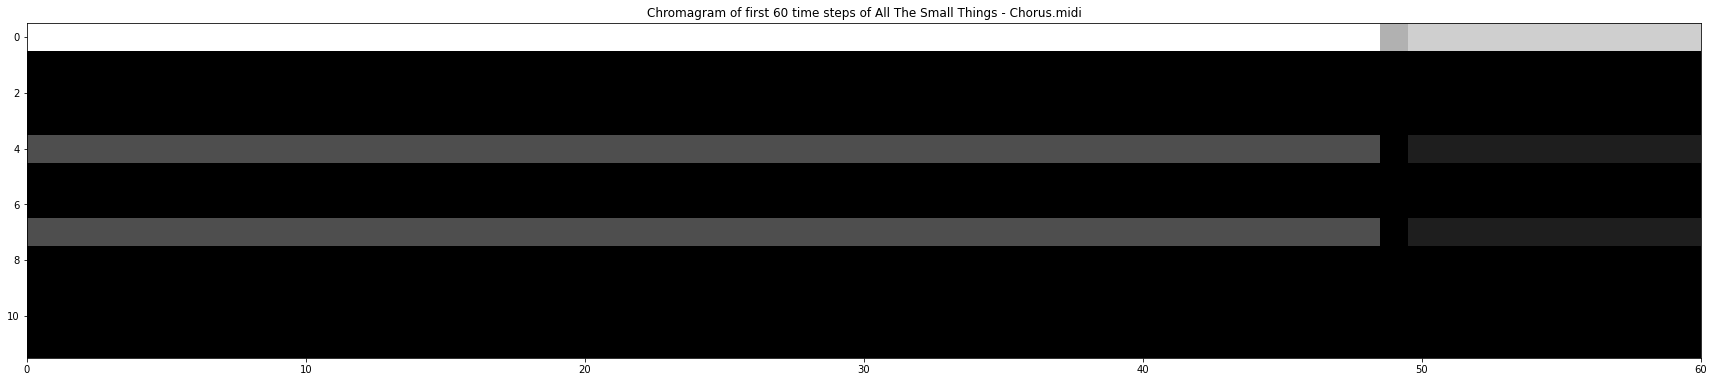

In [171]:
sample_midi = pretty_midi.PrettyMIDI(sample)

plt.figure(figsize=(30, 10))
plt.imshow(sample_midi.get_chroma(), "gray")
plt.xlim([0, 60])
plt.title(f"Chromagram of first 60 time steps of {song_name}")
plt.show()

piano roll shape (128, 511)


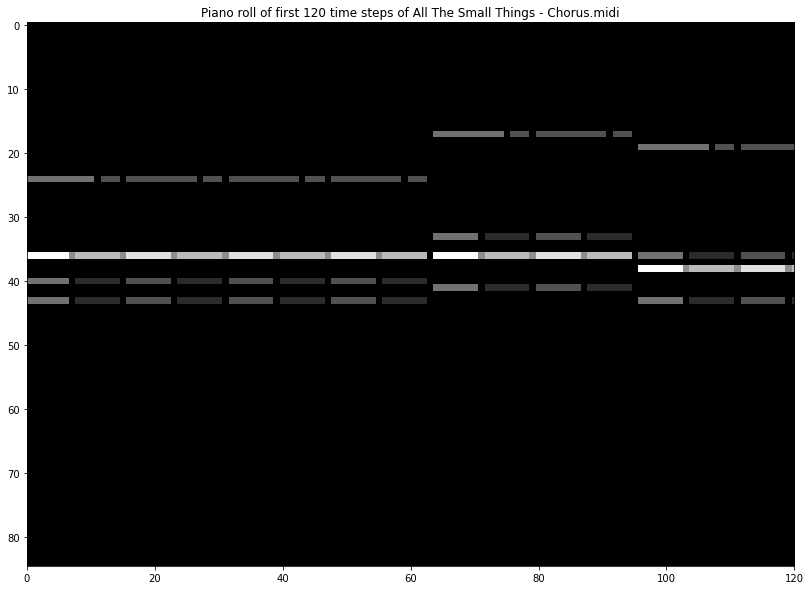

In [145]:
piano_roll = sample_midi.get_piano_roll(fs=16)
print("piano roll shape", piano_roll.shape)

plt.figure(figsize=(15, 10))
plt.imshow(piano_roll[24:109], "gray")  # Only pitches between 24 and 109 (C1 - C8)
plt.xlim([0, 120])
plt.title(f"Piano roll of first 120 time steps of {song_name}")
plt.show()

### Debugging `forward`

The utility function `forward` does some extra preprocessing and adds information. here we breakdown each step for our sample song and see their effects

The first step is to remove velocity, i.e. each note has only a on/off step

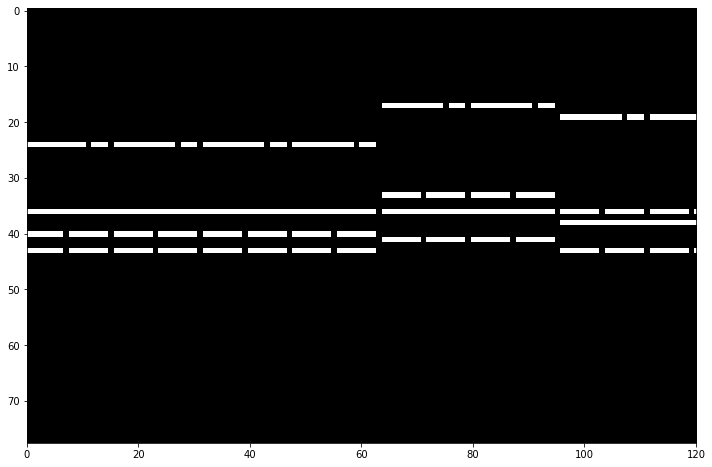

In [88]:
t = piano_roll

ret = t[
    24:102, :
]  # Pitches between C1 and F7 (perhaps it was meant to be 108 which is C8)

# Standardize velocity (i.e. have only note on or off)
for i in np.arange(np.shape(ret)[0]):
    for j in np.arange(np.shape(ret)[1]):
        if ret[i, j] > 0:
            ret[i, j] = 1

plt.figure(figsize=(15, 8))
plt.imshow(ret, "gray")  # Only pitches between 24 and 109 (C1 - C8)
plt.xlim([0, 120])
plt.show()

Next the array for `rhythm` is initialized, and has a value of 1 for each pitch in the piano roll that has a note played at t=0.

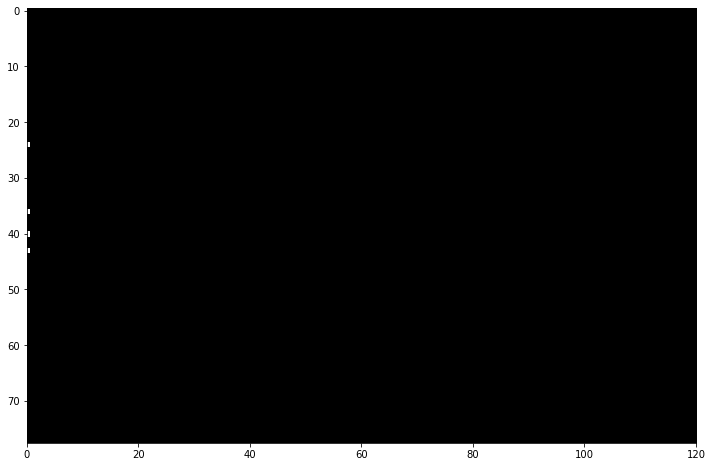

In [89]:
# Create an array for the rhythm
# The first loop initializes the
rhythm = np.zeros((78, np.shape(ret)[1]))
for i in np.arange(np.shape(ret)[0]):
    if ret[i, 0] > 0:
        rhythm[i, 0] = 1

plt.figure(figsize=(15, 8))
plt.imshow(rhythm, "gray")  # Only pitches between 24 and 109 (C1 - C8)
plt.xlim([0, 120])
plt.show()

Then he iterates through the piano roll and updates rhythm to indicate the note onsets.

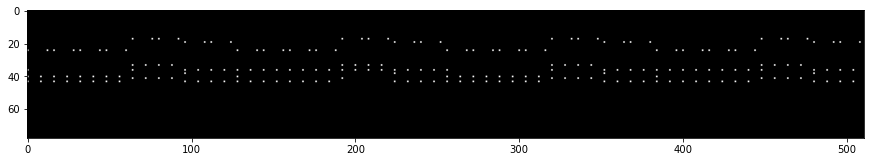

In [90]:
for i in np.arange(np.shape(ret)[0]):
    for j in np.arange(np.shape(ret)[1]):
        if j == 0:
            continue

        if ret[i, j] > 0 and ret[i, j - 1] == 0:
            rhythm[i, j] = 1


plt.figure(figsize=(15, 8))
plt.imshow(rhythm, "gray")  # Only pitches between 24 and 109 (C1 - C8)
plt.show()

Append the rhythm information to the song (concatenation along the 0th axis)

(156, 511)


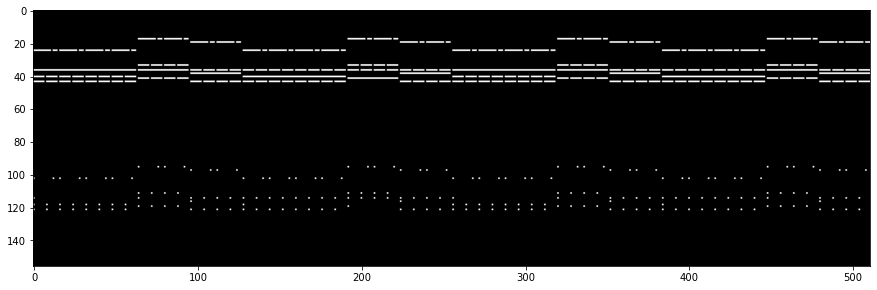

In [172]:
res = np.concatenate((ret, rhythm))
print(res.shape)

plt.figure(figsize=(15, 8))
plt.imshow(res, "gray")
plt.show()

Then only take every second note. I'm not sure why he does this.

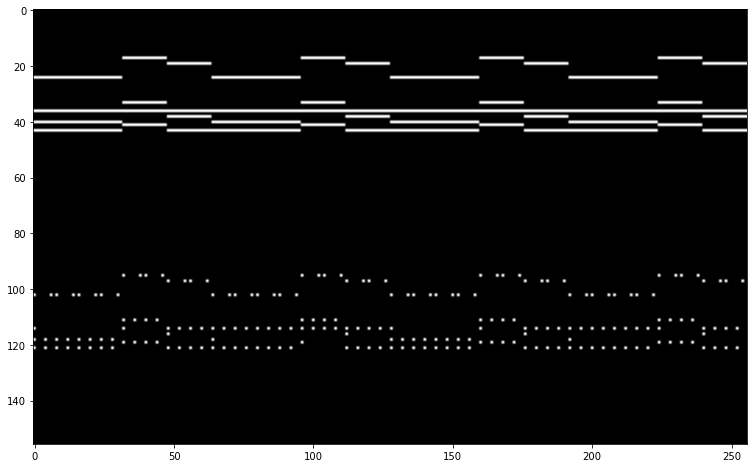

In [153]:
res = res[:, ::2]
plt.figure(figsize=(15, 8))
plt.imshow(res, "gray")
plt.show()

# Converted piano roll & chroma

The final piano roll contains the normalized pitches, the rhythm information and is transposed vertically (why? I don't know)

(256, 156)


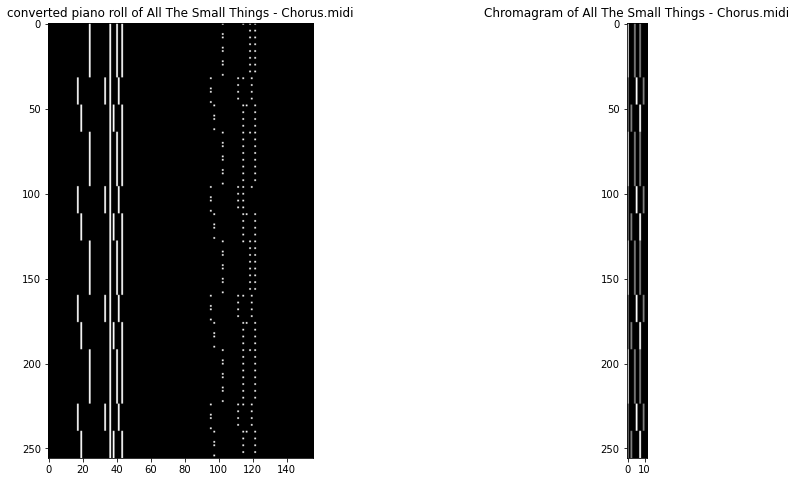

In [190]:
converted = convert.forward(piano_roll)
chroma = get_chromas([converted])[0]
print(converted.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(converted, "gray")
ax1.set_title(f"converted piano roll of {song_name}")
ax2.imshow(chroma, "gray")
ax2.set_title(f"Chromagram of {song_name}")
plt.show()

# Prep inside the training loop:

There is some further processing in the training loop to reshape the data.

In [159]:
low_note, high_note = 0, 78  # The index of lowest/highest note on the piano roll
note_range = high_note - low_note

n_timesteps = 4  # This is the number of timesteps that we will create at a time

Initial song shape: (256, 156)
Song has 64 timesteps of size 4
Shape after discarding remaining timesteps: (256, 156)
Final shape: (64, 624)


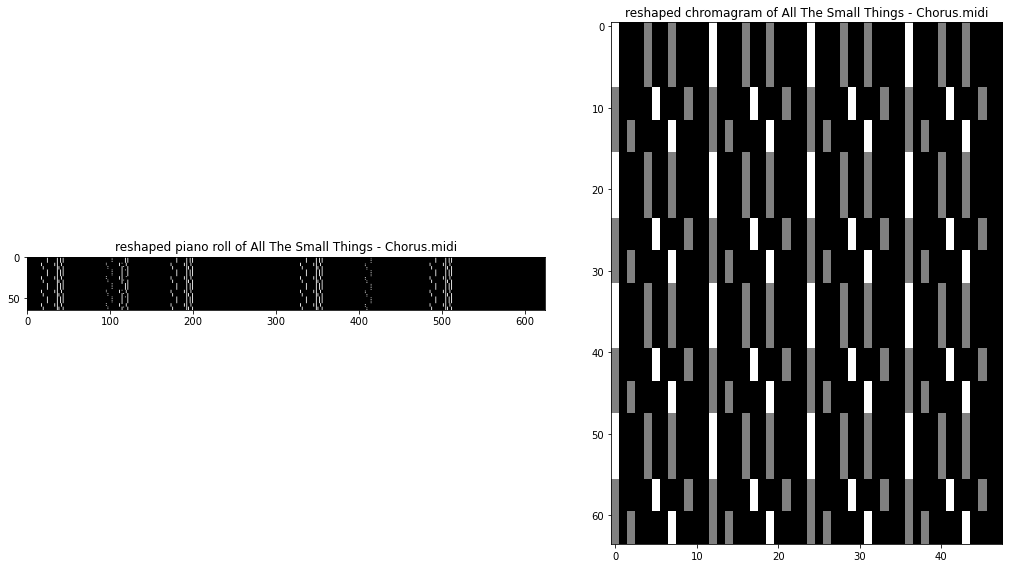

In [206]:
print("Initial song shape:", converted.shape)

song_timesteps = converted.shape[0] // n_timesteps
print(f"Song has {song_timesteps} timesteps of size {n_timesteps}")

song = converted[: song_timesteps * n_timesteps]  # discard any extra timesteps
song_chroma = chroma[: song_timesteps * n_timesteps]
print(f"Shape after discarding remaining timesteps: {song.shape}")

reshaped_song = song.reshape([song_timesteps, song.shape[1] * n_timesteps])
reshaped_chroma = chroma.reshape([song_timesteps, chroma.shape[1] * n_timesteps])
print(f"Final shape: {reshaped_song.shape}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(reshaped_song, "gray")
ax1.set_title(f"reshaped piano roll of {song_name}")
ax2.imshow(reshaped_chroma, "gray")
ax2.set_title(f"reshaped chromagram of {song_name}")
fig.tight_layout()

plt.show()

This doesn't look right to me... I feel like the output shouldn't be transposed. Furthermore, in the training loop, each `reshaped_song` is split into "batches" which get passed to the model, here's what they look like:

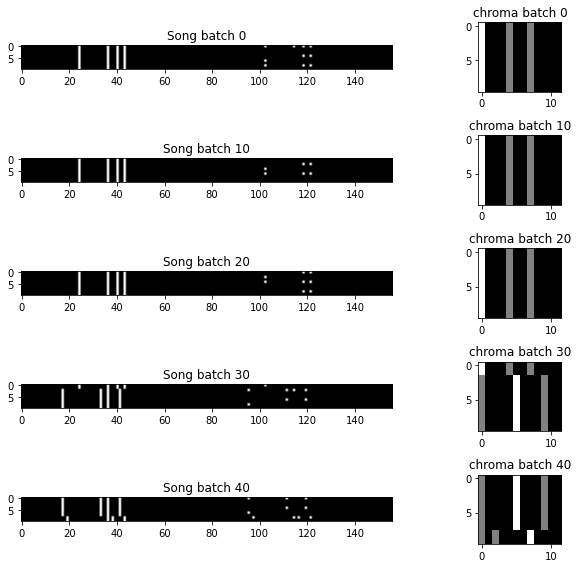

In [205]:
batch_size = 10

fig, axes = plt.subplots(5, 2, figsize=(10, 8))

for idx in range(0, 50, batch_size):
    batch_song = song[idx : idx + batch_size]
    batch_chroma = chroma[idx : idx + batch_size]

    axes[idx // 10, 0].imshow(batch_song, "gray")
    axes[idx // 10, 0].set_title(f"Song batch {idx}")

    axes[idx // 10, 1].imshow(batch_chroma, "gray")
    axes[idx // 10, 1].set_title(f"chroma batch {idx}")

fig.tight_layout()
plt.show()

# Claims:
#### 1. ChordGAN uses only 4/4 time signatures
#### 2. ChordGAN only trains on pieces longer than 50 timesteps

How to check it? Go through each of the songs in the datasets and check for tempo and number of timesteps